<a href="https://colab.research.google.com/github/Fadiabdf/OPT/blob/main/TP4/Metaheuristiques_a_populationV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tsplib95
!pip install springpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.2 MB/s eta 0:00:00
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstalled networkx-3.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires networkx>=3.0, but you have networkx 2.8.8 which is incompatible.
bigframes 2.1.0 requires tabulate>=0.9, but you have tabulate 0.8.10 which is incompatible.
nx-cugraph-cu12 25.2.0 requires networkx>=3.2, but you have networkx 2.8.8 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cubla

In [ ]:
# imports
import time
import random
import numpy as np
from math import ceil
import xml.etree.ElementTree as ET
import tsplib95
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

In [ ]:
#------------------------------------------------------------------------
# Charger et parser le fichier XML
instance = ('berlin52.xml')
problem = ET.parse(instance)
#------------------------------------------------------------------------
root = problem.getroot()  # la racine du fichier XML

# Dictionnaire pour stocker les données du graphe
graphe = {}

# Parcourir les sommets du graphe
for i, sommet in enumerate(root.find('graph').findall('vertex')):
    aretes = {}
    # Parcourir les arêtes du sommet actuel
    for arete in sommet.findall('edge'):
        cible = int(arete.text)  # ID du sommet cible
        cout = float(arete.get('cost'))
        aretes[cible] = cout
    graphe[i] = aretes  # Ajoute les arêtes au sommet correspondant


nombre_sommets = len(graphe)
print(f"Nombre de nœuds : {nombre_sommets}")

# Initialiser une matrice de distances avec des valeurs infinies
matrice_distances = np.full((nombre_sommets, nombre_sommets), np.inf)
matrice_distances = matrice_distances.astype(int)  # Convertit en entiers

# Remplir la matrice de distances avec les coûts extraits
for i, aretes in graphe.items():
    for j, cout in aretes.items():
        matrice_distances[i, j] = cout

# Définir la diagonale à zéro (distance d'un sommet à lui-même)
np.fill_diagonal(matrice_distances, 0)

# Sélectionner un sous-ensemble de la matrice pour les tests
#------------------------------------------------------------------------
n_sous_ensemble = 15#nombre_sommets  # Nombre de sommets à inclure dans le sous-ensemble
print(f"Nombre de nœuds à prendre pour le test : {n_sous_ensemble}")
sous_ensemble_matrice = matrice_distances[:n_sous_ensemble, :n_sous_ensemble]
#------------------------------------------------------------------------

# Convertir la matrice en liste pour une utilisation ultérieure
matrice_distances_liste = matrice_distances.tolist()
sous_ensemble_matrice_liste = sous_ensemble_matrice.tolist()



Nombre de nœuds : 52
Nombre de nœuds à prendre pour le test : 15


<ipython-input-4-9605fc445384>:27: RuntimeWarning: invalid value encountered in cast
  matrice_distances = matrice_distances.astype(int)  # Convertit en entiers


# **Métaheuristique Genitique:**

 Étapes d'un Algorithme Génétique

  1. Initialisation : Générer une population initiale de solutions aléatoires.
  2. Évaluation : Calculer la fitness (qualité) de chaque solution.
  3. Sélection : Choisir les solutions les plus performantes pour la reproduction.
  4. Croisement (Crossover) : Mélanger les solutions sélectionnées pour produire une nouvelle génération.
  5. Mutation : Modifier légèrement certaines solutions pour maintenir la diversité.
  6. Remplacement : Mettre à jour la population avec les nouvelles solutions.
  7. Répétition : Répéter les étapes jusqu’à un critère d'arrêt (nombre de générations, convergence…).

### **structure de données**

* Listes (list)
   - Les solutions candidates (parcours de villes).
   - Les distances entre villes (matrice_distances).
   - La population (ensemble des solutions).
   - Les coûts de chaque solution.
* Deque (collections.deque)
   - L'historique des coûts (coût moyen par génération, meilleur coût par génération).
   - Pourquoi une deque ? Car elle est plus rapide pour ajouter au bout par rapport à une liste normale.   

In [ ]:
import numpy as np
import random
from collections import deque

def calculer_cout(nombre_villes, matrice_distances, solution):
    """
    Calcule le coût total d'une solution (distance totale du parcours)

    Args:
        nombre_villes (int): Nombre de villes dans le problème
        matrice_distances (list): Matrice des distances entre les villes
        solution (list): Ordre de visite des villes (solution candidate)

    Returns:
        float: Distance totale du parcours
    """
    return sum([matrice_distances[solution[i]][solution[(i + 1) % nombre_villes]]
               for i in range(nombre_villes)])



def selection_tournoi(population, couts, taille_tournoi):
    """
    Sélection par tournoi - choisit le meilleur parmi un sous-ensemble aléatoire

    Args:
        population (list): Liste des solutions candidates
        couts (list): Coûts associés à chaque solution
        taille_tournoi (int): Nombre de participants au tournoi

    Returns:
        list: La solution sélectionnée
    """
    index_selectionne = np.random.randint(len(population))
    for i in np.random.randint(0, len(population), taille_tournoi - 1):
        if couts[i] < couts[index_selectionne]:
            index_selectionne = i
    return population[index_selectionne]


def selection_roulette(population, couts, _):
    """
    Sélection par roulette - probabilité proportionnelle à la performance

    Args:
        population (list): Liste des solutions candidates
        couts (list): Coûts associés à chaque solution
        _: Paramètre inutilisé (pour compatibilité)

    Returns:
        list: La solution sélectionnée
    """
    # Conversion des coûts en scores (évite les valeurs négatives)
    scores = [max(couts) - x for x in couts]
    somme_scores = sum(scores)
    return population[np.random.choice(len(population), p=[x/somme_scores for x in scores])]


def selection_elitiste(population, couts, _):
    """
    Sélection élitiste - choisit toujours la meilleure solution

    Args:
        population (list): Liste des solutions candidates
        couts (list): Coûts associés à chaque solution
        _: Paramètre inutilisé (pour compatibilité)

    Returns:
        list: La meilleure solution
    """
    return population[np.argmin(couts)]


def croisement(parent1, parent2, taux_croisement):
    """
    Croisement OX (Order Crossover) - préserve l'ordre des villes

    Args:
        parent1 (list): Premier parent
        parent2 (list): Deuxième parent
        taux_croisement (float): Probabilité d'effectuer le croisement

    Returns:
        list: Deux enfants issus du croisement
    """
    if random.random() < taux_croisement:
        enfant1, enfant2 = parent1.copy(), parent2.copy()
        point1 = random.randint(0, len(parent1)-1)
        point2 = random.randint(0, len(parent2)-1)

        # Assure que point1 < point2
        while point1 == point2:
            point2 = random.randint(0, len(parent2)-1)
        if point1 > point2:
            point1, point2 = point2, point1

        # Effectue le croisement
        for i in range(point2 - point1):
            enfant1.remove(parent2[point1 + i])
            enfant2.remove(parent1[point1 + i])

        return [
            enfant1[:point1] + parent2[point1:point2] + enfant1[point1:],
            enfant2[:point1] + parent1[point1:point2] + enfant2[point1:]
        ]
    else:
        return [parent1, parent2]


def mutation(solution, taux_mutation):
    """
    Mutation par inversion centrale (CIM) - inverse une partie du parcours

    Args:
        solution (list): Solution à muter
        taux_mutation (float): Probabilité d'effectuer la mutation

    Returns:
        list: Solution mutée (ou identique si pas de mutation)
    """
    if random.random() < taux_mutation:
        point_mutation = random.randint(0, len(solution)-1)
        return solution[:point_mutation][::-1] + solution[point_mutation:][::-1]
    else:
        return solution


def algorithme_genetique(nombre_villes, matrice_distances, taille_population,
                        taux_croisement, taux_mutation, methode_selection,
                        taille_tournoi, critere_arret):
    """
    Implémentation d'un algorithme génétique pour résoudre le PVC

    Args:
        nombre_villes (int): Nombre de villes à visiter
        matrice_distances (list): Matrice des distances entre villes
        taille_population (int): Nombre de solutions dans la population
        taux_croisement (float): Probabilité de croisement (0-1)
        taux_mutation (float): Probabilité de mutation (0-1)
        methode_selection (str): Méthode de sélection ('tournoi', 'roulette' ou 'elitiste')
        taille_tournoi (int): Taille du tournoi pour la sélection par tournoi
        critere_arret (int): Nombre d'itérations sans amélioration avant arrêt

    Returns:
        tuple: (meilleure_solution, meilleur_cout, historique)
    """
    # Initialisation de la population
    population = [random.sample(range(nombre_villes), nombre_villes)
                 for _ in range(taille_population)]

    meilleure_solution = population[0]
    meilleur_cout = calculer_cout(nombre_villes, matrice_distances, population[0])

    historique = {
        'cout_moyen': deque([]),
        'meilleur_cout': deque([])
    }

    compteur_sans_amelioration = 0

    # Choix de la méthode de sélection
    if methode_selection == 'tournoi':
        fonction_selection = selection_tournoi
    elif methode_selection == 'roulette':
        fonction_selection = selection_roulette
    elif methode_selection == 'elitiste':
        fonction_selection = selection_elitiste
    else:
        raise ValueError("Méthode de sélection inconnue")

    # Boucle principale de l'algorithme
    while True:
        # Évaluation de la population
        couts = [calculer_cout(nombre_villes, matrice_distances, sol)
                for sol in population]

        # Mise à jour de la meilleure solution
        dernier_meilleur_cout = meilleur_cout
        for i in range(taille_population):
            if couts[i] < meilleur_cout:
                meilleure_solution, meilleur_cout = population[i], couts[i]

        # Vérification du critère d'arrêt
        if dernier_meilleur_cout == meilleur_cout:
            compteur_sans_amelioration += 1
        else:
            compteur_sans_amelioration = 0

        # Enregistrement des statistiques
        historique['cout_moyen'].append(np.mean(couts))
        historique['meilleur_cout'].append(meilleur_cout)

        if compteur_sans_amelioration > critere_arret:
            return meilleure_solution, meilleur_cout, historique

        # Sélection des parents
        parents_selectionnes = [fonction_selection(population, couts, taille_tournoi)
                              for _ in range(taille_population)]

        # Création de la nouvelle génération
        nouvelle_generation = []
        for i in range(0, taille_population, 2):
            parent1, parent2 = parents_selectionnes[i], parents_selectionnes[i+1]

            # Croisement et mutation
            for enfant in croisement(parent1, parent2, taux_croisement):
                nouvelle_generation.append(mutation(enfant, taux_mutation))

        population = nouvelle_generation

300 est un compromis entre :

diversité (explorer plein d’ordres différents)

rapidité (temps d'exécution raisonnable)

 Avec 0.5, on mélange raisonnablement les parents pour créer de nouvelles combinaisons.

 Un taux de mutation élevé évite que la population se fige trop vite.
  beaucoup de diversité pour ne pas rester coincé dans un mauvais minimum local.

   Le tournoi est souvent le plus stable pour les problèmes difficiles comme TSP.

   Avec 3, on a un bon compromis entre sélection des meilleurs et chance de laisser passer une solution moyenne.


taille_population=300	   Assez de diversité, pas trop lent

taux_croisement=0.5	   Mélange raisonnable des solutions

taux_mutation=0.8   	Beaucoup de nouveauté pour éviter le blocage

methode_selection='tournoi'	  Équilibre chance/mérite

taille_tournoi=3	  Bon équilibre sélection/diversité

critere_arret=100	   Arrêter quand on stagne

In [ ]:
import time

# Enregistrement du temps de départ
temps_debut = time.time()

# Exécution de l'algorithme génétique
meilleure_solution, meilleur_cout, historique = algorithme_genetique(
    nombre_villes=52,
    matrice_distances=matrice_distances_liste,
    taille_population=300,
    taux_croisement=0.5,
    taux_mutation=0.8,
    methode_selection='tournoi',
    taille_tournoi=3,
    critere_arret=150
)

# Calcul du temps d'exécution
temps_execution = time.time() - temps_debut

# Affichage des résultats
print(f"\nRésultats de l'optimisation :")
print(f"-> Temps de calcul : {temps_execution:.2f} secondes")
print(f"-> Meilleure solution trouvée : {meilleure_solution}")
print(f"-> Distance totale minimale : {meilleur_cout:.2f} unités")

# Affichage des statistiques d'évolution
print("\nÉvolution de l'algorithme :")
print(f"- Dernier coût moyen : {historique['cout_moyen'][-1]:.2f}")
print(f"- Nombre d'itérations : {len(historique['meilleur_cout'])}")
print(f"- Amélioration totale : {historique['meilleur_cout'][0] - meilleur_cout:.2f} unités")


Résultats de l'optimisation :
-> Temps de calcul : 10.26 secondes
-> Meilleure solution trouvée : [25, 26, 27, 11, 24, 3, 5, 14, 4, 37, 39, 36, 23, 47, 45, 43, 33, 34, 38, 35, 48, 31, 0, 21, 17, 30, 22, 19, 49, 15, 28, 29, 1, 6, 41, 20, 16, 2, 44, 18, 40, 7, 8, 9, 42, 32, 50, 10, 51, 13, 12, 46]
-> Distance totale minimale : 7744.00 unités

Évolution de l'algorithme :
- Dernier coût moyen : 8603.17
- Nombre d'itérations : 970
- Amélioration totale : 17297.00 unités


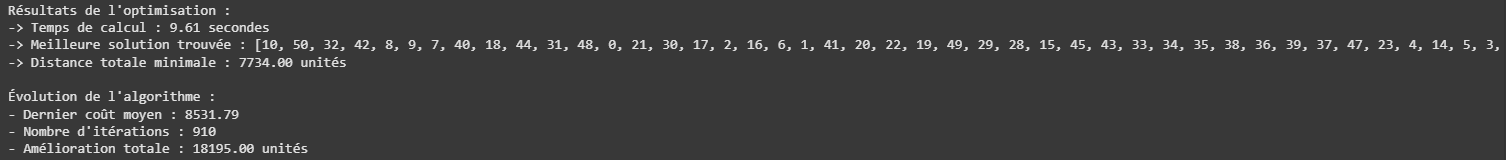

### ACO (Ant Colony Optimization) — Optimisation par Colonies de **Fourmis**

ACO est une métaheuristique inspirée du comportement des colonies de fourmis qui trouvent le plus court chemin entre leur nid et une source de nourriture.
Elles déposent une substance chimique appelée phéromone sur leur chemin : plus le chemin est court et utilisé, plus il est renforcé par les phéromones, incitant d'autres fourmis à l'emprunter.

# Algorithme de base :
À chaque itération, un certain nombre de fourmis (agents) construisent des tournées (solutions) probabilistes :

1.   Chaque fourmi commence dans une ville aléatoire.
2.   Elle construit sa tournée ville par ville, en choisissant la prochaine ville avec une probabilité basée sur deux facteurs :
 *   Phéromone : trace laissée par les autres fourmis
 *   Attractivité heuristique : inverse de la distance (plus c'est court, mieux c'est)
3.   Une fois toutes les tournées terminées :
 *   Les phéromones s’évaporent (diminuent)
 *   Les meilleures tournées renforcent les chemins qu’elles ont empruntés (ajout de phéromones)


# **Paramètres et leur rôle :**
- n_fourmis : Nombre de fourmis par itération. Plus il y en a, plus on explore.
- n_iterations : Nombre d’itérations (ou générations). Plus il est élevé, plus l’algorithme a de chances de converger vers une bonne solution.
- alpha : Influence des phéromones. Si élevé, les fourmis sont attirées par les chemins déjà marqués.
- beta : Influence de l’attractivité heuristique (1/distance). Si élevé, les fourmis préfèrent les chemins plus courts.
- Q : Quantité de phéromone déposée par une fourmi. Plus c’est grand, plus les bonnes solutions influencent les autres.
- pheromones : Matrice qui garde les niveaux de phéromone entre chaque paire de villes. Mise à jour après chaque itération.
- rho : Taux d’évaporation des phéromones (entre 0 et 1). Un rho élevé fait disparaître vite les anciennes traces, favorisant l’exploration.

In [ ]:
import random
import numpy as np

def aco_tsp(distances, n_fourmis=20, n_iterations=100, alpha=1, beta=5, rho=0.5, Q=100):
    # Nombre de villes dans le TSP
    n_villes = len(distances)
    distances = np.array(distances)

    # Initialisation de la matrice des phéromones : 1 partout au début
    pheromones = np.ones((n_villes, n_villes))

    # Variables pour stocker la meilleure tournée et sa distance
    meilleure_distance = float('inf')
    meilleure_tournee = []

    # Boucle principale sur les itérations
    for iteration in range(n_iterations):
        toutes_les_tournees = []
        toutes_les_distances = []

        # Chaque fourmi construit une tournée
        for _ in range(n_fourmis):
            non_visitees = list(range(n_villes))  # Villes restantes à visiter
            tournee = []

            # Choisir une ville de départ aléatoirement
            ville_courante = random.choice(non_visitees)
            tournee.append(ville_courante)
            non_visitees.remove(ville_courante)

            # Construire la tournée complète
            while non_visitees:
                proba = []

                # Calculer la probabilité de transition vers chaque ville non visitée
                for ville in non_visitees:
                    tau = pheromones[ville_courante][ville] ** alpha   # Influence des phéromones
                    eta = (1 / distances[ville_courante][ville]) ** beta if distances[ville_courante][ville] != 0 else 0  # Attractivité
                    proba.append(tau * eta)

                # Normalisation des probabilités
                somme = sum(proba)
                proba = [p / somme for p in proba]

                # Sélection probabiliste de la prochaine ville
                prochaine_ville = random.choices(non_visitees, weights=proba, k=1)[0]
                tournee.append(prochaine_ville)
                non_visitees.remove(prochaine_ville)
                ville_courante = prochaine_ville

            # Calcul de la distance totale de la tournée (avec retour à la ville de départ)
            distance_totale = sum(distances[tournee[i]][tournee[(i+1)%n_villes]] for i in range(n_villes))

            # Sauvegarder la tournée et sa distance
            toutes_les_tournees.append(tournee)
            toutes_les_distances.append(distance_totale)

            # Mise à jour de la meilleure solution si nécessaire
            if distance_totale < meilleure_distance:
                meilleure_distance = distance_totale
                meilleure_tournee = tournee

        # Évaporation des phéromones
        pheromones *= (1 - rho)

        # Mise à jour des phéromones avec les nouvelles tournées
        for i in range(n_fourmis):
            tour = toutes_les_tournees[i]
            dist = toutes_les_distances[i]

            for j in range(n_villes):
                de = tour[j]
                vers = tour[(j+1) % n_villes]  # Pour revenir à la ville de départ
                # Ajout de phéromone proportionnellement à la qualité de la tournée
                pheromones[de][vers] += Q / dist
                pheromones[vers][de] += Q / dist  # Symétrique car graphe non orienté

        # Affichage de l'évolution
       # print(f"Iteration {iteration+1}/{n_iterations} — Meilleure distance : {meilleure_distance:.2f}")

    return meilleure_tournee, meilleure_distance


In [ ]:
# Lancer l'algorithme sur le sous-ensemble
start_time = time.time()
tournee, distance = aco_tsp(sous_ensemble_matrice_liste, n_fourmis=30, n_iterations=100)
end_time = time.time()
temps_execution = end_time - start_time

print("\n--- Résultat final ---")
print("Distance optimale trouvée :", distance)
print("Tournée optimale :", tournee)
print("Temps d'exécution : {:.6f} secondes".format(temps_execution))


--- Résultat final ---
Distance optimale trouvée : 7674
Tournée optimale : [22, 19, 49, 15, 45, 43, 33, 34, 35, 38, 39, 37, 36, 47, 23, 4, 14, 5, 3, 24, 11, 27, 26, 25, 46, 13, 12, 51, 10, 50, 32, 42, 9, 8, 7, 40, 18, 44, 31, 48, 0, 21, 30, 17, 2, 16, 20, 1, 6, 41, 29, 28]
Temps d'exécution : 7.080298 secondes


# **3. Grey Wolf Optimizer (GWO) — TSP**

Initialisation	Créer des solutions aléatoires

Sélection	Identifier Alpha, Beta, Delta (meilleurs tours)

Perturbation	Modifier légèrement Alpha, Beta, Delta pour créer de nouvelles solutions

Mise à jour	Remplacer un loup si une meilleure solution est trouvée

Répétition	Pendant plusieurs itérations

Résultat final	Meilleur chemin trouvé

In [ ]:
def gwo_tsp(distances, n_loups=200, n_iterations=200):
    n_villes = len(distances)
    distances = np.array(distances)

    def fitness(tour):
        return sum(distances[tour[i]][tour[(i+1)%n_villes]] for i in range(n_villes))

    def perturb(tour):
        i, j = sorted(random.sample(range(n_villes), 2))
        new_tour = tour[:i] + tour[i:j][::-1] + tour[j:]
        return new_tour

    loups = [random.sample(range(n_villes), n_villes) for _ in range(n_loups)]
    scores = [fitness(t) for t in loups]

    for iteration in range(n_iterations):
        sorted_loups = [x for _, x in sorted(zip(scores, loups))]
        alpha, beta, delta = sorted_loups[:3]

        for i in range(n_loups):
            new = []
            for j in range(3):
                parent = [alpha, beta, delta][j]
                pert = perturb(parent)
                new.append(pert)
            combined = min(new, key=fitness)
            if fitness(combined) < fitness(loups[i]):
                loups[i] = combined

        scores = [fitness(t) for t in loups]
        print(f"Itération {iteration+1}/{n_iterations} — Meilleure distance : {min(scores):.2f}")

    best_idx = np.argmin(scores)
    return loups[best_idx], scores[best_idx]


In [ ]:
start_time = time.time()
solution, cout = gwo_tsp(matrice_distances_liste)
end_time = time.time()
temps_execution = end_time - start_time
print("Solution trouvée :", solution)
print("Coût total :", cout)
print("Temps d'exécution : {:.6f} secondes".format(temps_execution))

Itération 1/200 — Meilleure distance : 24395.00
Itération 2/200 — Meilleure distance : 23268.00
Itération 3/200 — Meilleure distance : 21522.00
Itération 4/200 — Meilleure distance : 20810.00
Itération 5/200 — Meilleure distance : 19812.00
Itération 6/200 — Meilleure distance : 19186.00
Itération 7/200 — Meilleure distance : 18282.00
Itération 8/200 — Meilleure distance : 17678.00
Itération 9/200 — Meilleure distance : 17081.00
Itération 10/200 — Meilleure distance : 16455.00
Itération 11/200 — Meilleure distance : 15945.00
Itération 12/200 — Meilleure distance : 15435.00
Itération 13/200 — Meilleure distance : 14900.00
Itération 14/200 — Meilleure distance : 14593.00
Itération 15/200 — Meilleure distance : 14134.00
Itération 16/200 — Meilleure distance : 13315.00
Itération 17/200 — Meilleure distance : 13085.00
Itération 18/200 — Meilleure distance : 12724.00
Itération 19/200 — Meilleure distance : 12311.00
Itération 20/200 — Meilleure distance : 12020.00
Itération 21/200 — Meilleure 

Méthode,Distance Minimale,Temps d'exécution (s),Tournée optimale
Algorithme Génétique,7734,9.61,"[25, 26, 27, 11, 24, 3, 5, 14, 4, 37, 39, 36, 23, 47, 45, 43, 33, 34, 38, 35, 48, 31, 0, 21, 17, 30, 22, 19, 49, 15, 28, 29, 1, 6, 41, 20, 16, 2, 44, 18, 40, 7, 8, 9, 42, 32, 50, 10, 51, 13, 12, 46]"
Colonies de Fourmis,7674,7.08,"[22, 19, 49, 15, 45, 43, 33, 34, 35, 38, 39, 37, 36, 47, 23, 4, 14, 5, 3, 24, 11, 27, 26, 25, 46, 13, 12, 51, 10, 50, 32, 42, 9, 8, 7, 40, 18, 44, 31, 48, 0, 21, 30, 17, 2, 16, 20, 1, 6, 41, 29, 28]"
Grey Wolf Optimizer,8019,4.58,"[8, 9, 42, 32, 50, 11, 10, 51, 12, 13, 46, 25, 26, 27, 45, 24, 3, 5, 14, 4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 15, 28, 49, 19, 29, 41, 1, 6, 16, 2, 17, 30, 20, 22, 21, 0, 48, 31, 44, 18, 40, 7]"


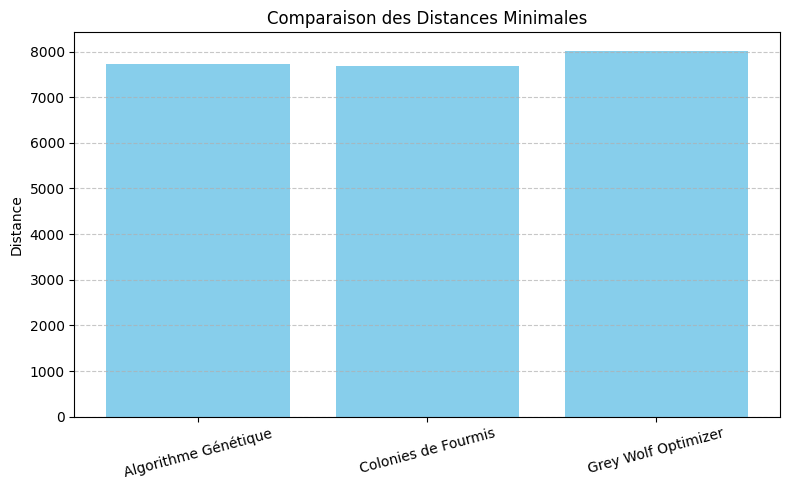

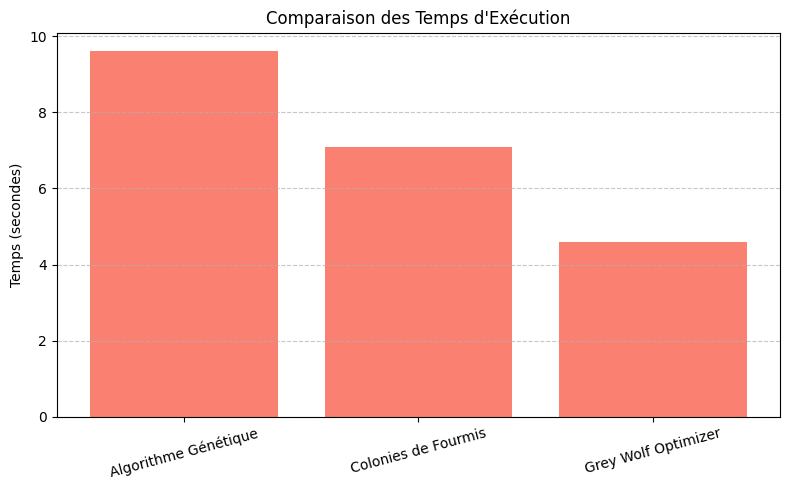

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Données
data = {
    "Méthode": ["Algorithme Génétique", "Colonies de Fourmis", "Grey Wolf Optimizer"],
    "Distance Minimale": [7734, 7674, 8019],
    "Temps d'exécution (s)": [9.61, 7.08, 4.58],
    "Tournée optimale": [
        "[25, 26, 27, 11, 24, 3, 5, 14, 4, 37, 39, 36, 23, 47, 45, 43, 33, 34, 38, 35, 48, 31, 0, 21, 17, 30, 22, 19, 49, 15, 28, 29, 1, 6, 41, 20, 16, 2, 44, 18, 40, 7, 8, 9, 42, 32, 50, 10, 51, 13, 12, 46]",
        "[22, 19, 49, 15, 45, 43, 33, 34, 35, 38, 39, 37, 36, 47, 23, 4, 14, 5, 3, 24, 11, 27, 26, 25, 46, 13, 12, 51, 10, 50, 32, 42, 9, 8, 7, 40, 18, 44, 31, 48, 0, 21, 30, 17, 2, 16, 20, 1, 6, 41, 29, 28]",
        "[8, 9, 42, 32, 50, 11, 10, 51, 12, 13, 46, 25, 26, 27, 45, 24, 3, 5, 14, 4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 15, 28, 49, 19, 29, 41, 1, 6, 16, 2, 17, 30, 20, 22, 21, 0, 48, 31, 44, 18, 40, 7]"
    ]
}

# Création du DataFrame
df = pd.DataFrame(data)

# Affichage du tableau
display(df.style.set_caption("Comparaison des Métaheuristiques pour le Problème du Voyageur de Commerce (TSP)")
            .format({"Distance Minimale": "{:.0f}", "Temps d'exécution (s)": "{:.2f}"})
            .hide(axis="index"))

# === Diagramme en barres : Distance Minimale ===
plt.figure(figsize=(8, 5))
plt.bar(df["Méthode"], df["Distance Minimale"], color="skyblue")
plt.title("Comparaison des Distances Minimales")
plt.ylabel("Distance")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# === Diagramme en barres : Temps d'exécution ===
plt.figure(figsize=(8, 5))
plt.bar(df["Méthode"], df["Temps d'exécution (s)"], color="salmon")
plt.title("Comparaison des Temps d'Exécution")
plt.ylabel("Temps (secondes)")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Méthode,Meilleur Coût,Temps (s)
Algorithme Génétique,7734,9.61
Colonies de Fourmis,7674,7.08
Grey Wolf Optimizer,8019,4.58
Simulated Annealing,7900,5.20
Tabu Search,7800,6.10
Hill Climbing,8000,3.90


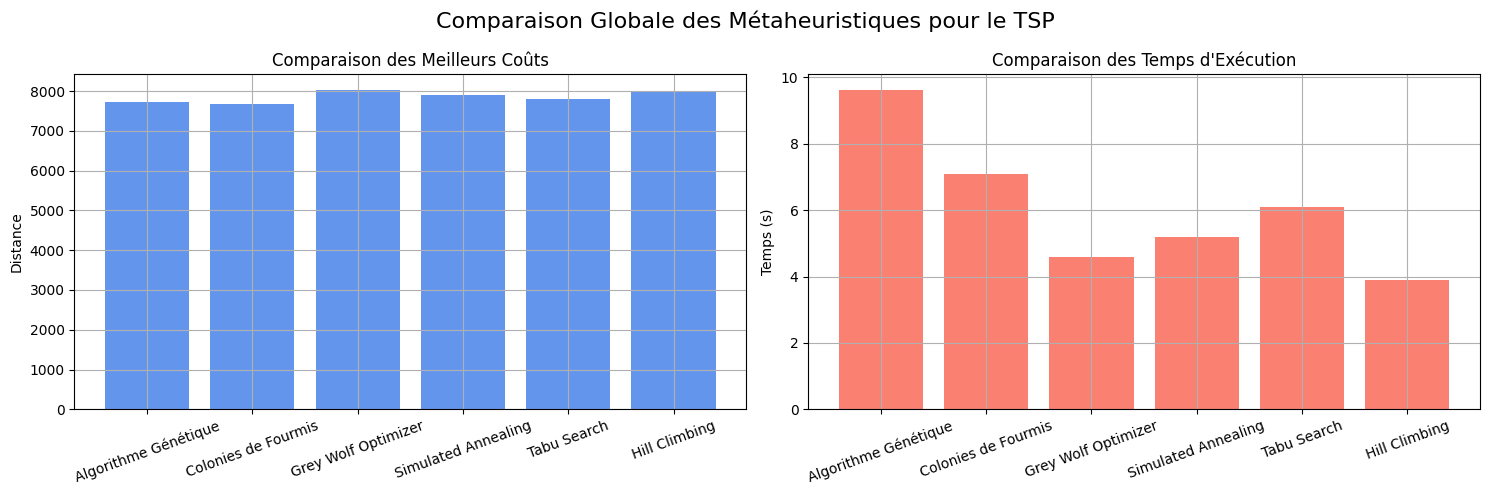

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Résultats fixes pour GA, ACO, GWO
fixed_results = {
    'Méthode': ['Algorithme Génétique', 'Colonies de Fourmis', 'Grey Wolf Optimizer'],
    'Meilleur Coût': [7734, 7674, 8019],
    'Temps (s)': [9.61, 7.08, 4.58]
}
sa_results = [{'cost': 7900, 'time': 5.2}, {'cost': 7950, 'time': 5.5}]
tabu_results = [{'cost': 7800, 'time': 6.1}, {'cost': 7820, 'time': 6.3}]
hc_results = [{'cost': 8000, 'time': 3.9}, {'cost': 8050, 'time': 4.1}]

# Résultats dynamiques pour SA, Tabu, HC
# Ces trois listes doivent être définies avant d'exécuter ce script :
# Exemple :
# sa_results = [{'cost': 7900, 'time': 5.2}, ...]
# tabu_results = [{'cost': 7800, 'time': 6.1}, ...]
# hc_results = [{'cost': 8000, 'time': 3.9}, ...]

dynamic_results = {
    'Méthode': ['Simulated Annealing', 'Tabu Search', 'Hill Climbing'],
    'Meilleur Coût': [
        min([r['cost'] for r in sa_results]),
        min([r['cost'] for r in tabu_results]),
        min([r['cost'] for r in hc_results])
    ],
    'Temps (s)': [
        min([r['time'] for r in sa_results]),
        min([r['time'] for r in tabu_results]),
        min([r['time'] for r in hc_results])
    ]
}

# Création des DataFrames
df_fixed = pd.DataFrame(fixed_results)
df_dynamic = pd.DataFrame(dynamic_results)

# Fusion des deux
df_all = pd.concat([df_fixed, df_dynamic], ignore_index=True)

# Affichage du tableau
display(df_all.style.set_caption("Comparaison des Métaheuristiques pour le TSP")
                  .format({"Meilleur Coût": "{:.0f}", "Temps (s)": "{:.2f}"})
                  .hide(axis="index"))

# Graphiques comparatifs
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Coût
ax[0].bar(df_all["Méthode"], df_all["Meilleur Coût"], color='cornflowerblue')
ax[0].set_title("Comparaison des Meilleurs Coûts")
ax[0].set_ylabel("Distance")
ax[0].tick_params(axis='x', rotation=20)
ax[0].grid(True)

# Temps
ax[1].bar(df_all["Méthode"], df_all["Temps (s)"], color='salmon')
ax[1].set_title("Comparaison des Temps d'Exécution")
ax[1].set_ylabel("Temps (s)")
ax[1].tick_params(axis='x', rotation=20)
ax[1].grid(True)

plt.suptitle("Comparaison Globale des Métaheuristiques pour le TSP", fontsize=16)
plt.tight_layout()
plt.show()
